In [1]:
# imports
import pandas as pd
import folium
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# import vacation data
vacation = pd.read_csv('./data/vacation_geo.csv')
vacation['Name'] = vacation[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(vacation.columns)
print(vacation.shape)
vacation.head()

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(47, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Highland,Denver,Colorado,USA,39.761133,-105.026392,"Highland, Denver, Colorado, USA"
1,Lodo,Denver,Colorado,USA,39.758270,-104.997257,"Lodo, Denver, Colorado, USA"
2,River North,Denver,Colorado,USA,39.768557,-104.980489,"River North, Denver, Colorado, USA"
3,Manitou Springs,Manitou Springs,Colorado,USA,38.854896,-104.898813,"Manitou Springs, Manitou Springs, Colorado, USA"
4,Downtown,Atlanta,Georgia,USA,33.759502,-84.387993,"Downtown, Atlanta, Georgia, USA"


In [3]:
# check locations
vacation[['Region','Country']].value_counts()

Region          Country
Ontario         Canada     11
Quebec          Canada      5
Georgia         USA         5
Tokyo           Japan       4
Florida         USA         4
Colorado        USA         4
California      USA         3
Tennessee       USA         2
South Carolina  USA         2
Kyoto           Japan       2
Yamanashi       Japan       1
Osaka           Japan       1
Nara            Japan       1
Louisiana       USA         1
Alabama         USA         1
dtype: int64

In [4]:
# visualize vacation locations
latitude = vacation.lat.mean()
longitude = (vacation.lon.max() + vacation.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, name in zip(vacation['lat'], 
                          vacation['lon'],
                          vacation['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [5]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
vacation_venues = getNearbyVenues(names=vacation['Name'],
                                 latitudes=vacation['lat'],
                                 longitudes=vacation['lon']
                                )
print("All done!")

All done!


In [8]:
print(vacation_venues.shape)
vacation_venues.head()

(2787, 7)


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Highland Park,39.762880,-105.026054,Park
1,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Tacos Tequila Whiskey,39.762012,-105.030019,Taco Place
2,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Orangetheory Fitness,39.762002,-105.030061,Gym
3,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Starbucks,39.760393,-105.024941,Coffee Shop
4,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Denver Bread Company,39.762274,-105.030000,Bakery


In [9]:
print('There are {} uniques categories.'.format(len(vacation_venues['Venue Category'].unique())))

There are 324 uniques categories.


Lots of coffee shops!
count            2787
unique            324
top       Coffee Shop
freq              140
Name: Venue Category, dtype: object 

Coffee Shop            140
Café                   127
Hotel                  115
Bar                     74
Japanese Restaurant     72
Italian Restaurant      54
Pizza Place             52
Restaurant              49
American Restaurant     37
Bakery                  36
Name: Venue Category, dtype: int64 

Coffee Shop            0.050233
Café                   0.045569
Hotel                  0.041263
Bar                    0.026552
Japanese Restaurant    0.025834
Italian Restaurant     0.019376
Pizza Place            0.018658
Restaurant             0.017582
American Restaurant    0.013276
Bakery                 0.012917
Name: Venue Category, dtype: float64 

Exhibit               1
Home Service          1
Buddhist Temple       1
Beer Store            1
Outdoor Sculpture     1
Pet Café              1
IT Services           1
African Restaurant

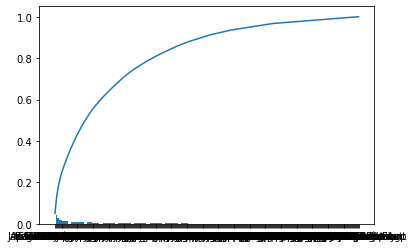

In [10]:
print("Lots of coffee shops!")
print(vacation_venues['Venue Category'].describe(),'\n')
t = vacation_venues['Venue Category'].value_counts(normalize=True)
n = vacation_venues['Venue Category'].value_counts()
print(n.head(10),'\n')
print(t.head(10),'\n')
print(n.tail(10),'\n')
x = t.index.values
h = t.values
c = h.cumsum()
plt.bar(x, h)
plt.plot(x, c)

In [11]:
# derive features with one hot encoding
vacation_onehot = pd.get_dummies(vacation_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
vacation_onehot['Name'] = vacation_venues['Name'] 

# move postal code column to the first column
fixed_columns = [vacation_onehot.columns[-1]] + list(vacation_onehot.columns[:-1])
vacation_onehot = vacation_onehot[fixed_columns]

name_counts = vacation_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
print(name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]),'\n')
vacation_hot_counts = vacation_onehot.merge(name_counts, on='Name')

print(vacation_hot_counts.shape,'\n')
print('Some locations only have a few venues.')
print('Some have up to 100.')

       Count
0.00    1.00
0.05    6.30
0.10    9.40
0.25   29.50
0.33   39.18
0.50   61.00
0.67   91.00
0.75  100.00
0.90  100.00
0.95  100.00
1.00  100.00 

(2787, 326) 

Some locations only have a few venues.
Some have up to 100.


In [12]:
# look for locations with few venues
mask = name_counts['Count'] < 10
name_counts[mask].sort_values('Count')

,Name,Count
46,"Mountain Top, Mentone, Alabama, USA",1
45,"Tybee Island, Savannah, Georgia, USA",4
44,"Cinco Bayou, Fort Walton Beach, Florida, USA",6
42,"Little River, Little River, California, USA",7
43,"PCB, Panama City Beach, Florida, USA",7


In [13]:
# group by postal code and take mean by venue type
vacation_grouped = vacation_hot_counts.groupby('Name').mean().reset_index()
print(vacation_grouped.shape)
vacation_grouped.head()

(47, 326)


,Name,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Count
0,"Alexandra Park, Toronto, Ontario, Canada",0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.02,0.020000,...,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.020000,0.00,100
1,"Asakusa, Taitō, Tokyo, Japan",0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.00,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.04,100
2,"Casa Loma, Toronto, Ontario, Canada",0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.037037,0.00,27
3,"Chinatown, Montreal, Quebec, Canada",0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.021978,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,91
4,"Chinatown, Toronto, Ontario, Canada",0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.018182,...,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,55


In [14]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
X = np.nan_to_num(X)
pca_dataset = StandardScaler().fit_transform(X)

           0    cumsum
0   0.063939  0.063939
1   0.047925  0.111864
2   0.045406  0.157269
3   0.043615  0.200885
4   0.042618  0.243503
5   0.039948  0.283451
6   0.037511  0.320961
7   0.036737  0.357698
8   0.036285  0.393984
9   0.033930  0.427913
10  0.033083  0.460996
11  0.032622  0.493617
12  0.030576  0.524194
13  0.030332  0.554525
14  0.028620  0.583145
15  0.028428  0.611572
16  0.027692  0.639265
17  0.026779  0.666044
18  0.025999  0.692043
19  0.025745  0.717788
20  0.024452  0.742239
21  0.022912  0.765151
22  0.022709  0.787860
23  0.022086  0.809946
24  0.021430  0.831376 

                                       Name         0         1
0  Alexandra Park, Toronto, Ontario, Canada  0.016580 -0.011654
1              Asakusa, Taitō, Tokyo, Japan -0.032848 -0.049281
2       Casa Loma, Toronto, Ontario, Canada  0.020441 -0.032570
3       Chinatown, Montreal, Quebec, Canada -0.004669 -0.048637
4       Chinatown, Toronto, Ontario, Canada  0.042984  0.000318 



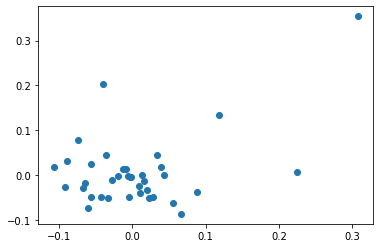

In [17]:
pca = PCA()
pca.fit(pca_dataset)
pca_comps = pd.DataFrame(pca.components_)
pca_comps['Name'] = vacation_grouped['Name'] 
pca_plot = pca_comps.iloc[:, [-1, 0, 1]]
pca_var = pd.DataFrame(pca.explained_variance_ratio_)
pca_var['cumsum'] = pca.explained_variance_ratio_.cumsum()
print(pca_var.head(25),'\n')
print(pca_comps.iloc[0:5, [-1, 0, 1]],'\n')
plt.scatter(pca_plot[0], pca_plot[1])

In [19]:
# determine best number of clusters
vacation_grouped_clustering = pca_comps.iloc[:, 0:25]
#vacation_grouped_clustering = pca_comps.iloc[:, 0:50]
#vacation_grouped_clustering = pca_comps.drop('Name',1)
#vacation_grouped_clustering = pca_dataset
sil = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(vacation_grouped_clustering)
    sil.append([silhouette_score(vacation_grouped_clustering, kmeans.labels_)])
    print("K: ",k)
    print("Clusters:")
    # check cluster labels generated for each row in the dataframe
    print(pd.DataFrame(kmeans.labels_).value_counts())
    # Calculate silhouette_score
    print("Silhouette: ",silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")
    
np.mean(sil)

K:  2
Clusters:
0    36
1     1
dtype: int64
Silhouette:  0.5660176157813323 

K:  3
Clusters:
2    19
1    17
0     1
dtype: int64
Silhouette:  0.05478992640518843 

K:  4
Clusters:
0    13
1    12
3    11
2     1
dtype: int64
Silhouette:  0.03893096905981732 

K:  5
Clusters:
2    15
4    11
1     7
0     3
3     1
dtype: int64
Silhouette:  0.047044138094904174 

K:  6
Clusters:
2    12
4    11
3     6
0     6
5     1
1     1
dtype: int64
Silhouette:  0.02808729134700956 

K:  7
Clusters:
5    11
4    10
1     7
0     4
6     2
2     2
3     1
dtype: int64
Silhouette:  0.054345905707356694 

K:  8
Clusters:
7    9
6    7
1    7
2    5
0    5
4    2
5    1
3    1
dtype: int64
Silhouette:  0.0503670761188779 

K:  9
Clusters:
7    9
2    9
1    8
4    4
5    2
0    2
8    1
6    1
3    1
dtype: int64
Silhouette:  0.041627766854085924 

K:  10
Clusters:
1    7
6    6
5    6
9    4
3    4
0    4
7    2
4    2
8    1
2    1
dtype: int64
Silhouette:  0.04611949526589881 

K:  11
Clusters:


0.08344765178468602

In [20]:
kmeans = KMeans(n_clusters=7).fit(vacation_grouped_clustering)
print(pd.DataFrame(kmeans.labels_).value_counts())
print("Silhouette: ", silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")

4    11
0     9
5     8
2     4
6     2
3     2
1     1
dtype: int64
Silhouette:  0.04345707394285146 



In [23]:
# import seattle data
seattle = pd.read_csv('./data/seattle_geo.csv')
seattle['Name'] = seattle[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(seattle.columns)
print(seattle.shape)
seattle.head()

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(17, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Downtown,Seattle,Washington,USA,47.607581,-122.336146,"Downtown, Seattle, Washington, USA"
1,West Seattle,Seattle,Washington,USA,47.566933,-122.387116,"West Seattle, Seattle, Washington, USA"
2,Capitol Hill,Seattle,Washington,USA,47.625067,-122.321201,"Capitol Hill, Seattle, Washington, USA"
3,Ballard,Seattle,Washington,USA,47.677038,-122.386494,"Ballard, Seattle, Washington, USA"
4,Queen Anne,Seattle,Washington,USA,47.632492,-122.357077,"Queen Anne, Seattle, Washington, USA"


In [25]:
# visualize Seattle neighborhoods
latitude = seattle.lat.mean()
longitude = (seattle.lon.max() + seattle.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(seattle['lat'], 
                          seattle['lon'],
                          seattle['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [26]:
# process the seattle data
seattle_venues = getNearbyVenues(names=seattle['Name'],
                                 latitudes=seattle['lat'],
                                 longitudes=seattle['lon']
                                )
print("All done!")

All done!


In [31]:
print(seattle_venues.shape)
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))
seattle_venues.head()

(917, 7)
There are 221 uniques categories.


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Benaroya Hall,47.607957,-122.336456,Concert Hall
1,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Seattle Art Museum,47.607052,-122.337819,Art Museum
2,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Gelatiamo,47.608754,-122.336992,Dessert Shop
3,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,The Capital Grille,47.608115,-122.335077,American Restaurant
4,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,The 5th Avenue Theatre,47.608996,-122.334162,Theater


In [32]:
# derive features with one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
seattle_onehot['Name'] = seattle_venues['Name'] 

# move postal code column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

name_counts = seattle_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
print(name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]),'\n')
seattle_hot_counts = seattle_onehot.merge(name_counts, on='Name')

print(seattle_hot_counts.shape,'\n')
print('Some locations only have a few venues.')
print('Some have up to 100.')

       Count
0.00    4.00
0.05    8.80
0.10   11.80
0.25   31.00
0.33   34.84
0.50   42.00
0.67   72.04
0.75   97.00
0.90  100.00
0.95  100.00
1.00  100.00 

(917, 223) 

Some locations only have a few venues.
Some have up to 100.


In [33]:
# group by postal code and take mean by venue type
seattle_grouped = seattle_hot_counts.groupby('Name').mean().reset_index()
print(seattle_grouped.shape)
seattle_grouped.head()

(17, 223)


,Name,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Count
0,"Ballard, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,10
1,"Beacon Hill, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,4
2,"Belltown, Seattle, Washington, USA",0.0,0.0,0.013514,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.027027,0.0,0.000000,0.0,0.0,0.000000,0.0,74
3,"Capitol Hill, Seattle, Washington, USA",0.0,0.0,0.108108,0.0,0.0,0.0,0.027027,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.027027,0.0,0.0,0.027027,0.0,37
4,"Central District, Seattle, Washington, USA",0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,13


In [36]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
X = np.nan_to_num(X)
stnd = StandardScaler().fit(X)
S = seattle_grouped.drop('Name', 1)
S = np.nan_to_num(X)
seattle_stnd = stnd.transform(S)

In [41]:
seattle_pca = pca.transform(seattle_stnd)
seattle_comps = pd.DataFrame(seattle_pca)
seattle_comps['Name'] = seattle_grouped['Name'] 
seattle_comps.iloc[0:5, [-1,0,1]]

,Name,0,1
0,"Ballard, Seattle, Washington, USA",-1.834397,-3.537178
1,"Beacon Hill, Seattle, Washington, USA",16.118452,2.560325
2,"Belltown, Seattle, Washington, USA",-3.384602,1.475749
3,"Capitol Hill, Seattle, Washington, USA",0.737881,-0.677815
4,"Central District, Seattle, Washington, USA",-0.872737,-0.236802


In [44]:
seattle_grouped_clustering = seattle_comps.iloc[:, 0:25]

In [51]:
seattle_clusters = kmeans.predict(seattle_grouped_clustering)
seattle_clusters[0:5]

array([3, 2, 1, 6, 4])

In [42]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html